In [2]:
from rdkit import Chem
import sys
import os
import useful_rdkit_utils as uru
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import Descriptors
import matplotlib.pyplot as plt
import itertools
import pandas as pd
from collections import Counter
import mols2grid
from tdc.single_pred import ADME
from Filtering_functions import filter_molecules
import glob

In [3]:
# Get the current working directory
current_dir = os.getcwd()
print(current_dir)
# Get the parent directory
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
print(parent_dir)
# Add the parent directory to sys.path
sys.path.append(parent_dir)

/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/3D_generative_SBDD
/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model


Set the default image size

In [4]:
uru.rd_set_image_size(300,300)

### Reading the data from 3D_generative_SBDD

See if they are valid or not

In [5]:
smi_list = []
with open('/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/3D_generative_SBDD/combined_SMILES_3D_generative.txt') as f:
    for smi in f:
        smi_list.append(smi.strip())
standardized_smiles_list = []
for smi in smi_list:
    mol = Chem.MolFromSmiles(smi)
    if mol:
        standardized_smiles_list.append(Chem.MolToSmiles(mol))

print(len(smi_list))
len(standardized_smiles_list)

1750


[20:20:31] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6
[20:20:31] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 6 8
[20:20:31] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[20:20:31] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[20:20:31] Explicit valence for atom # 3 N, 4, is greater than permitted
[20:20:31] Explicit valence for atom # 7 N, 4, is greater than permitted
[20:20:31] Explicit valence for atom # 6 N, 4, is greater than permitted
[20:20:31] Explicit valence for atom # 8 N, 4, is greater than permitted
[20:20:31] Explicit valence for atom # 8 N, 4, is greater than permitted
[20:20:31] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
[20:20:31] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[20:20:31] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 7
[20:20:31] Explicit valence for atom # 4 N, 4, is greater than permitted
[20:20:31] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 8 9 11 12
[20:20:31] Explicit valence for atom # 13 N, 4, is gre

1732

Convert SMILES and name of them to a dataframe

In [6]:
df = pd.DataFrame(standardized_smiles_list, columns=['SMILES'])
df

,SMILES
0,OC1CCCN1
1,OC1C=CC=N1
2,CC(C)CNNCC(C)(N)O
3,CC1(O)NCCC1NCC1CCCN1
4,CC(N)(O)C([NH])NCC1CC=CCC1
...,...
1727,CCOP(=O)(O)O
1728,CC(C)OP(=O)(O)O
1729,C=CCCOP(=O)(O)O
1730,O=P(O)(O)OCCC1CN1


Add an RDKit molecule to the dataframe

In [7]:
df['mol'] = df.SMILES.apply(Chem.MolFromSmiles)

Strip salts from the molecule

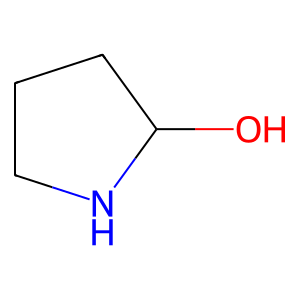

In [8]:
df.mol = df.mol.apply(uru.get_largest_fragment)
df.mol[0]

Instantiate a RingSystemFinder object and find ring systems for the molecules in df

In [9]:
ring_system_finder = uru.RingSystemFinder()
df['ring_sytems'] = df.mol.apply(ring_system_finder.find_ring_systems)
df.ring_sytems

0                [C1CCNC1]
1              [C1=CCN=C1]
2                       []
3       [C1CCNC1, C1CCNC1]
4              [C1=CCCCC1]
               ...        
1727                    []
1728                    []
1729                    []
1730               [C1CN1]
1731           [C1=CN=NC1]
Name: ring_sytems, Length: 1732, dtype: object

In [10]:
df.ring_sytems.values

array([list(['C1CCNC1']), list(['C1=CCN=C1']), list([]), ..., list([]),
       list(['C1CN1']), list(['C1=CN=NC1'])], dtype=object)

See how many times each ring system occurs

In [11]:
ring_system_list = list(itertools.chain.from_iterable(df.ring_sytems.values))
ring_count_df = pd.DataFrame(Counter(ring_system_list).items(),columns=["SMILES","Count"]) ### Convert a dictionary to a DataFrame.
ring_count_df.sort_values("Count",ascending=False,inplace=True)
ring_count_df

,SMILES,Count
5,c1ccccc1,157
26,C1CC1,85
22,C1CO1,57
32,C1CN1,54
68,c1ccncc1,45
...,...,...
222,O=C1NCCC2CN12,1
221,O=C1CCCCCN1,1
220,O=C1C2CCNCN12,1
218,C1CCCNCCC1,1


View the ring system frequencies

In [12]:
mols2grid.display(ring_count_df,subset=["img","Count"])

MolGridWidget()

The RingSystemLookup object has a dictionary of how many times each ring system occurs in the ChEMBL database.  We can use this object to evaluate the molecules in df.

In [13]:
ring_system_lookup = uru.RingSystemLookup.default()
res = df.mol.apply(ring_system_lookup.process_mol)

In [14]:
res

0                          [(C1CCNC1, 112428)]
1                            [(C1=CCN=C1, 40)]
2                                           []
3       [(C1CCNC1, 112428), (C1CCNC1, 112428)]
4                          [(C1=CCCCC1, 7200)]
                         ...                  
1727                                        []
1728                                        []
1729                                        []
1730                           [(C1CN1, 1537)]
1731                          [(C1=CN=NC1, 5)]
Name: mol, Length: 1732, dtype: object

In [15]:
df[['min_ring','min_freq']] = res.apply(uru.get_min_ring_frequency).tolist()
df

,SMILES,mol,ring_sytems,min_ring,min_freq
0,OC1CCCN1,<rdkit.Chem.rdchem.Mol object at 0x7e059b9747b0>,[C1CCNC1],C1CCNC1,112428
1,OC1C=CC=N1,<rdkit.Chem.rdchem.Mol object at 0x7e059b9749e0>,[C1=CCN=C1],C1=CCN=C1,40
2,CC(C)CNNCC(C)(N)O,<rdkit.Chem.rdchem.Mol object at 0x7e059b974a50>,[],,-1
3,CC1(O)NCCC1NCC1CCCN1,<rdkit.Chem.rdchem.Mol object at 0x7e059b974ac0>,"[C1CCNC1, C1CCNC1]",C1CCNC1,112428
4,CC(N)(O)C([NH])NCC1CC=CCC1,<rdkit.Chem.rdchem.Mol object at 0x7e059b974b30>,[C1=CCCCC1],C1=CCCCC1,7200
...,...,...,...,...,...
1727,CCOP(=O)(O)O,<rdkit.Chem.rdchem.Mol object at 0x7e059b9a8350>,[],,-1
1728,CC(C)OP(=O)(O)O,<rdkit.Chem.rdchem.Mol object at 0x7e059b9a83c0>,[],,-1
1729,C=CCCOP(=O)(O)O,<rdkit.Chem.rdchem.Mol object at 0x7e059b9a8430>,[],,-1
1730,O=P(O)(O)OCCC1CN1,<rdkit.Chem.rdchem.Mol object at 0x7e059b9a84a0>,[C1CN1],C1CN1,1537


In [16]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

### Check how many molecules are unique the ring frequency of them

How many molecules are unique using inChI?

In [17]:
df['inchi'] = df.mol.apply(Chem.MolToInchi)
df = df.drop_duplicates("inchi", keep="first", ignore_index=True)
df

[20:20:33] WARNING: Omitted undefined stereo

[20:20:33] WARNING: Omitted undefined stereo

[20:20:33] WARNING: Omitted undefined stereo

[20:20:33] WARNING: Omitted undefined stereo

[20:20:33] WARNING: Accepted unusual valence(s): N(2); Omitted undefined stereo

[20:20:33] WARNING: Omitted undefined stereo

[20:20:33] WARNING: Omitted undefined stereo

[20:20:33] WARNING: Accepted unusual valence(s): N(2); Omitted undefined stereo

[20:20:33] WARNING: Accepted unusual valence(s): N(2); Omitted undefined stereo

[20:20:33] WARNING: Omitted undefined stereo

[20:20:33] WARNING: Omitted undefined stereo

[20:20:33] WARNING: Omitted undefined stereo

[20:20:33] WARNING: Omitted undefined stereo

[20:20:33] WARNING: Omitted undefined stereo

[20:20:33] WARNING: Omitted undefined stereo

[20:20:33] WARNING: Omitted undefined stereo

[20:20:33] WARNING: Omitted undefined stereo

[20:20:33] WARNING: Omitted undefined stereo

[20:20:33] WARNING: Omitted undefined stereo

[20:20:33] WARNING: A

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi
0,OC1CCCN1,<rdkit.Chem.rdchem.Mol object at 0x7e059b9747b0>,[C1CCNC1],C1CCNC1,112428,"InChI=1S/C4H9NO/c6-4-2-1-3-5-4/h4-6H,1-3H2"
1,OC1C=CC=N1,<rdkit.Chem.rdchem.Mol object at 0x7e059b9749e0>,[C1=CCN=C1],C1=CCN=C1,40,"InChI=1S/C4H5NO/c6-4-2-1-3-5-4/h1-4,6H"
2,CC(C)CNNCC(C)(N)O,<rdkit.Chem.rdchem.Mol object at 0x7e059b974a50>,[],,-1,"InChI=1S/C7H19N3O/c1-6(2)4-9-10-5-7(3,8)11/h6,..."
3,CC1(O)NCCC1NCC1CCCN1,<rdkit.Chem.rdchem.Mol object at 0x7e059b974ac0>,"[C1CCNC1, C1CCNC1]",C1CCNC1,112428,InChI=1S/C10H21N3O/c1-10(14)9(4-6-13-10)12-7-8...
4,CC(N)(O)C([NH])NCC1CC=CCC1,<rdkit.Chem.rdchem.Mol object at 0x7e059b974b30>,[C1=CCCCC1],C1=CCCCC1,7200,"InChI=1S/C10H20N3O/c1-10(12,14)9(11)13-7-8-5-3..."
...,...,...,...,...,...,...
1496,OC[PH](O)(O)O,<rdkit.Chem.rdchem.Mol object at 0x7e059b9a8200>,[],,-1,"InChI=1S/CH7O4P/c2-1-6(3,4)5/h2-6H,1H2"
1497,COP(=O)(O)O,<rdkit.Chem.rdchem.Mol object at 0x7e059b9a8270>,[],,-1,"InChI=1S/CH5O4P/c1-5-6(2,3)4/h1H3,(H2,2,3,4)"
1498,CC(C)OP(=O)(O)O,<rdkit.Chem.rdchem.Mol object at 0x7e059b9a83c0>,[],,-1,"InChI=1S/C3H9O4P/c1-3(2)7-8(4,5)6/h3H,1-2H3,(H..."
1499,O=P(O)(O)OCCC1CN1,<rdkit.Chem.rdchem.Mol object at 0x7e059b9a84a0>,[C1CN1],C1CN1,1537,"InChI=1S/C4H10NO4P/c6-10(7,8)9-2-1-4-3-5-4/h4-..."


How many molecules contains ring structure?

In [18]:
df_ring = df[df.min_freq != -1]
df_ring

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi
0,OC1CCCN1,<rdkit.Chem.rdchem.Mol object at 0x7e059b9747b0>,[C1CCNC1],C1CCNC1,112428,"InChI=1S/C4H9NO/c6-4-2-1-3-5-4/h4-6H,1-3H2"
1,OC1C=CC=N1,<rdkit.Chem.rdchem.Mol object at 0x7e059b9749e0>,[C1=CCN=C1],C1=CCN=C1,40,"InChI=1S/C4H5NO/c6-4-2-1-3-5-4/h1-4,6H"
3,CC1(O)NCCC1NCC1CCCN1,<rdkit.Chem.rdchem.Mol object at 0x7e059b974ac0>,"[C1CCNC1, C1CCNC1]",C1CCNC1,112428,InChI=1S/C10H21N3O/c1-10(14)9(4-6-13-10)12-7-8...
4,CC(N)(O)C([NH])NCC1CC=CCC1,<rdkit.Chem.rdchem.Mol object at 0x7e059b974b30>,[C1=CCCCC1],C1=CCCCC1,7200,"InChI=1S/C10H20N3O/c1-10(12,14)9(11)13-7-8-5-3..."
5,CC1CC(O)(CN=CC2CCCC2)NO1,<rdkit.Chem.rdchem.Mol object at 0x7e059b974ba0>,"[C1CNOC1, C1CCCC1]",C1CNOC1,586,"InChI=1S/C11H20N2O2/c1-9-6-11(14,13-15-9)8-12-..."
...,...,...,...,...,...,...
1493,COc1ccc(CCC2CCNCC2)cc1,<rdkit.Chem.rdchem.Mol object at 0x7e059b9a7f40>,"[c1ccccc1, C1CCNCC1]",C1CCNCC1,174309,InChI=1S/C14H21NO/c1-16-14-6-4-12(5-7-14)2-3-1...
1494,Fc1cc(F)c2cc3c(nc2c1)CNCC3,<rdkit.Chem.rdchem.Mol object at 0x7e059b9a8040>,[c1ccc2nc3c(cc2c1)CCNC3],c1ccc2nc3c(cc2c1)CCNC3,0,InChI=1S/C12H10F2N2/c13-8-4-10(14)9-3-7-1-2-15...
1495,COc1ccc2c(c1)C2CC1=CCNCC1,<rdkit.Chem.rdchem.Mol object at 0x7e059b9a80b0>,"[c1ccc2c(c1)C2, C1=CCNCC1]",c1ccc2c(c1)C2,0,InChI=1S/C14H17NO/c1-16-11-2-3-12-13(14(12)9-1...
1499,O=P(O)(O)OCCC1CN1,<rdkit.Chem.rdchem.Mol object at 0x7e059b9a84a0>,[C1CN1],C1CN1,1537,"InChI=1S/C4H10NO4P/c6-10(7,8)9-2-1-4-3-5-4/h4-..."


In [19]:
filtered_df_ring_freq = df[(df.min_freq > 100) & (df.min_freq != -1)]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi
0,OC1CCCN1,<rdkit.Chem.rdchem.Mol object at 0x7e059b9747b0>,[C1CCNC1],C1CCNC1,112428,"InChI=1S/C4H9NO/c6-4-2-1-3-5-4/h4-6H,1-3H2"
3,CC1(O)NCCC1NCC1CCCN1,<rdkit.Chem.rdchem.Mol object at 0x7e059b974ac0>,"[C1CCNC1, C1CCNC1]",C1CCNC1,112428,InChI=1S/C10H21N3O/c1-10(14)9(4-6-13-10)12-7-8...
4,CC(N)(O)C([NH])NCC1CC=CCC1,<rdkit.Chem.rdchem.Mol object at 0x7e059b974b30>,[C1=CCCCC1],C1=CCCCC1,7200,"InChI=1S/C10H20N3O/c1-10(12,14)9(11)13-7-8-5-3..."
5,CC1CC(O)(CN=CC2CCCC2)NO1,<rdkit.Chem.rdchem.Mol object at 0x7e059b974ba0>,"[C1CNOC1, C1CCCC1]",C1CNOC1,586,"InChI=1S/C11H20N2O2/c1-9-6-11(14,13-15-9)8-12-..."
6,CC1(O)NCCC1NCc1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x7e059b974c10>,"[C1CCNC1, c1ccccc1]",C1CCNC1,112428,InChI=1S/C12H18N2O/c1-12(15)11(7-8-14-12)13-9-...
...,...,...,...,...,...,...
1488,COc1ccc(CC2C=CNCC2)cc1,<rdkit.Chem.rdchem.Mol object at 0x7e059b9a7d10>,"[c1ccccc1, C1=CNCCC1]",C1=CNCCC1,122,InChI=1S/C13H17NO/c1-15-13-4-2-11(3-5-13)10-12...
1490,C1=CC(Cc2ccc3c(c2)OCO3)CCN1,<rdkit.Chem.rdchem.Mol object at 0x7e059b9a7df0>,"[C1=CNCCC1, c1ccc2c(c1)OCO2]",C1=CNCCC1,122,InChI=1S/C13H15NO2/c1-2-12-13(16-9-15-12)8-11(...
1492,c1cc2c(cc1CC1CCNCC1)OCO2,<rdkit.Chem.rdchem.Mol object at 0x7e059b9a7ed0>,"[c1ccc2c(c1)OCO2, C1CCNCC1]",c1ccc2c(c1)OCO2,23197,InChI=1S/C13H17NO2/c1-2-12-13(16-9-15-12)8-11(...
1493,COc1ccc(CCC2CCNCC2)cc1,<rdkit.Chem.rdchem.Mol object at 0x7e059b9a7f40>,"[c1ccccc1, C1CCNCC1]",C1CCNCC1,174309,InChI=1S/C14H21NO/c1-16-14-6-4-12(5-7-14)2-3-1...


### How many of them could pass PAINS filter?

Get a list of rules

In [20]:
reos = uru.REOS()
reos.get_available_rule_sets()

array(['Glaxo', 'Dundee', 'BMS', 'PAINS', 'SureChEMBL', 'MLSMR',
       'Inpharmatica', 'LINT'], dtype=object)

Get the currently active rule sets

In [21]:
reos.get_active_rule_sets()

array(['Glaxo'], dtype=object)

Set active rule set to PAINS

In [22]:
reos.set_active_rule_sets(['PAINS'])
reos.get_active_rule_sets()

array(['PAINS'], dtype=object)

Apply PAINS filter to unique mols

In [23]:
new_df = reos.pandas_mols(df.mol)
len(new_df[new_df.description == "ok"])

  0%|          | 0/1501 [00:00<?, ?it/s]

1487

In [24]:
df_PAINS_filter = pd.concat([df, reos.pandas_mols(df.mol)], axis=1)
df_PAINS_filter = df_PAINS_filter[df_PAINS_filter.description == 'ok']
df_PAINS_filter

  0%|          | 0/1501 [00:00<?, ?it/s]

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,rule_set_name,description
0,OC1CCCN1,<rdkit.Chem.rdchem.Mol object at 0x7e059b9747b0>,[C1CCNC1],C1CCNC1,112428,"InChI=1S/C4H9NO/c6-4-2-1-3-5-4/h4-6H,1-3H2",ok,ok
1,OC1C=CC=N1,<rdkit.Chem.rdchem.Mol object at 0x7e059b9749e0>,[C1=CCN=C1],C1=CCN=C1,40,"InChI=1S/C4H5NO/c6-4-2-1-3-5-4/h1-4,6H",ok,ok
2,CC(C)CNNCC(C)(N)O,<rdkit.Chem.rdchem.Mol object at 0x7e059b974a50>,[],,-1,"InChI=1S/C7H19N3O/c1-6(2)4-9-10-5-7(3,8)11/h6,...",ok,ok
3,CC1(O)NCCC1NCC1CCCN1,<rdkit.Chem.rdchem.Mol object at 0x7e059b974ac0>,"[C1CCNC1, C1CCNC1]",C1CCNC1,112428,InChI=1S/C10H21N3O/c1-10(14)9(4-6-13-10)12-7-8...,ok,ok
4,CC(N)(O)C([NH])NCC1CC=CCC1,<rdkit.Chem.rdchem.Mol object at 0x7e059b974b30>,[C1=CCCCC1],C1=CCCCC1,7200,"InChI=1S/C10H20N3O/c1-10(12,14)9(11)13-7-8-5-3...",ok,ok
...,...,...,...,...,...,...,...,...
1496,OC[PH](O)(O)O,<rdkit.Chem.rdchem.Mol object at 0x7e059b9a8200>,[],,-1,"InChI=1S/CH7O4P/c2-1-6(3,4)5/h2-6H,1H2",ok,ok
1497,COP(=O)(O)O,<rdkit.Chem.rdchem.Mol object at 0x7e059b9a8270>,[],,-1,"InChI=1S/CH5O4P/c1-5-6(2,3)4/h1H3,(H2,2,3,4)",ok,ok
1498,CC(C)OP(=O)(O)O,<rdkit.Chem.rdchem.Mol object at 0x7e059b9a83c0>,[],,-1,"InChI=1S/C3H9O4P/c1-3(2)7-8(4,5)6/h3H,1-2H3,(H...",ok,ok
1499,O=P(O)(O)OCCC1CN1,<rdkit.Chem.rdchem.Mol object at 0x7e059b9a84a0>,[C1CN1],C1CN1,1537,"InChI=1S/C4H10NO4P/c6-10(7,8)9-2-1-4-3-5-4/h4-...",ok,ok


Test all filters in rd_filter

In [26]:
rd_filters = ['Glaxo', 'Dundee', 'BMS', 'SureChEMBL', 'MLSMR', 'Inpharmatica', 'LINT']
for filter in rd_filters:
    reos.set_active_rule_sets([filter])
    new_df = reos.pandas_mols(df.mol)
    print(filter, len(new_df[new_df.description == "ok"])/len(new_df), reos.get_active_rule_sets(), len(new_df[new_df.description == "ok"]))

  0%|          | 0/1501 [00:00<?, ?it/s]

Glaxo 0.7674883411059293 ['Glaxo'] 1152


  0%|          | 0/1501 [00:00<?, ?it/s]

Dundee 0.4390406395736176 ['Dundee'] 659


  0%|          | 0/1501 [00:00<?, ?it/s]

BMS 0.6922051965356429 ['BMS'] 1039


  0%|          | 0/1501 [00:00<?, ?it/s]

SureChEMBL 0.6289140572951366 ['SureChEMBL'] 944


  0%|          | 0/1501 [00:00<?, ?it/s]

MLSMR 0.47968021319120585 ['MLSMR'] 720


  0%|          | 0/1501 [00:00<?, ?it/s]

Inpharmatica 0.7015323117921386 ['Inpharmatica'] 1053


  0%|          | 0/1501 [00:00<?, ?it/s]

LINT 0.5256495669553631 ['LINT'] 789


### How many of them could pass filters suggested by Dr.Reymond?

In [24]:
df['Reymond'] = df.mol.apply(filter_molecules)
df

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond
0,OC1CCCN1,<rdkit.Chem.rdchem.Mol object at 0x7289d59b3ed0>,[C1CCNC1],C1CCNC1,112428,"InChI=1S/C4H9NO/c6-4-2-1-3-5-4/h4-6H,1-3H2",True
1,OC1C=CC=N1,<rdkit.Chem.rdchem.Mol object at 0x7289d59b3f40>,[C1=CCN=C1],C1=CCN=C1,40,"InChI=1S/C4H5NO/c6-4-2-1-3-5-4/h1-4,6H",True
2,CC(C)CNNCC(C)(N)O,<rdkit.Chem.rdchem.Mol object at 0x7289d59b8040>,[],,-1,"InChI=1S/C7H19N3O/c1-6(2)4-9-10-5-7(3,8)11/h6,...",True
3,CC1(O)NCCC1NCC1CCCN1,<rdkit.Chem.rdchem.Mol object at 0x7289d59b80b0>,"[C1CCNC1, C1CCNC1]",C1CCNC1,112428,InChI=1S/C10H21N3O/c1-10(14)9(4-6-13-10)12-7-8...,True
4,CC(N)(O)C([NH])NCC1CC=CCC1,<rdkit.Chem.rdchem.Mol object at 0x7289d59b8120>,[C1=CCCCC1],C1=CCCCC1,7200,"InChI=1S/C10H20N3O/c1-10(12,14)9(11)13-7-8-5-3...",True
...,...,...,...,...,...,...,...
1496,OC[PH](O)(O)O,<rdkit.Chem.rdchem.Mol object at 0x7289d59e7760>,[],,-1,"InChI=1S/CH7O4P/c2-1-6(3,4)5/h2-6H,1H2",True
1497,COP(=O)(O)O,<rdkit.Chem.rdchem.Mol object at 0x7289d59e77d0>,[],,-1,"InChI=1S/CH5O4P/c1-5-6(2,3)4/h1H3,(H2,2,3,4)",True
1498,CC(C)OP(=O)(O)O,<rdkit.Chem.rdchem.Mol object at 0x7289d59e7920>,[],,-1,"InChI=1S/C3H9O4P/c1-3(2)7-8(4,5)6/h3H,1-2H3,(H...",True
1499,O=P(O)(O)OCCC1CN1,<rdkit.Chem.rdchem.Mol object at 0x7289d59e7a00>,[C1CN1],C1CN1,1537,"InChI=1S/C4H10NO4P/c6-10(7,8)9-2-1-4-3-5-4/h4-...",True


In [25]:
df_Reymond_filter = df[df.Reymond == True]
df_Reymond_filter

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond
0,OC1CCCN1,<rdkit.Chem.rdchem.Mol object at 0x7289d59b3ed0>,[C1CCNC1],C1CCNC1,112428,"InChI=1S/C4H9NO/c6-4-2-1-3-5-4/h4-6H,1-3H2",True
1,OC1C=CC=N1,<rdkit.Chem.rdchem.Mol object at 0x7289d59b3f40>,[C1=CCN=C1],C1=CCN=C1,40,"InChI=1S/C4H5NO/c6-4-2-1-3-5-4/h1-4,6H",True
2,CC(C)CNNCC(C)(N)O,<rdkit.Chem.rdchem.Mol object at 0x7289d59b8040>,[],,-1,"InChI=1S/C7H19N3O/c1-6(2)4-9-10-5-7(3,8)11/h6,...",True
3,CC1(O)NCCC1NCC1CCCN1,<rdkit.Chem.rdchem.Mol object at 0x7289d59b80b0>,"[C1CCNC1, C1CCNC1]",C1CCNC1,112428,InChI=1S/C10H21N3O/c1-10(14)9(4-6-13-10)12-7-8...,True
4,CC(N)(O)C([NH])NCC1CC=CCC1,<rdkit.Chem.rdchem.Mol object at 0x7289d59b8120>,[C1=CCCCC1],C1=CCCCC1,7200,"InChI=1S/C10H20N3O/c1-10(12,14)9(11)13-7-8-5-3...",True
...,...,...,...,...,...,...,...
1496,OC[PH](O)(O)O,<rdkit.Chem.rdchem.Mol object at 0x7289d59e7760>,[],,-1,"InChI=1S/CH7O4P/c2-1-6(3,4)5/h2-6H,1H2",True
1497,COP(=O)(O)O,<rdkit.Chem.rdchem.Mol object at 0x7289d59e77d0>,[],,-1,"InChI=1S/CH5O4P/c1-5-6(2,3)4/h1H3,(H2,2,3,4)",True
1498,CC(C)OP(=O)(O)O,<rdkit.Chem.rdchem.Mol object at 0x7289d59e7920>,[],,-1,"InChI=1S/C3H9O4P/c1-3(2)7-8(4,5)6/h3H,1-2H3,(H...",True
1499,O=P(O)(O)OCCC1CN1,<rdkit.Chem.rdchem.Mol object at 0x7289d59e7a00>,[C1CN1],C1CN1,1537,"InChI=1S/C4H10NO4P/c6-10(7,8)9-2-1-4-3-5-4/h4-...",True


### How many of them could pass RO5?

In [26]:
def passes_rule_of_five(smiles):
    """Determine if a molecule passes Lipinski's Rule of Five."""
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        hbd = Descriptors.NumHDonors(mol)  # Hydrogen bond donors
        hba = Descriptors.NumHAcceptors(mol)  # Hydrogen bond acceptors
        mw = Descriptors.MolWt(mol)  # Molecular weight
        logp = Descriptors.MolLogP(mol)  # LogP
        
        # Check Lipinski's Rule of Five criteria
        if hbd <= 5 and hba <= 10 and mw <= 500 and logp <= 5:
            return True
    return False

df['Lipinski'] = df.SMILES.apply(passes_rule_of_five)
df

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,OC1CCCN1,<rdkit.Chem.rdchem.Mol object at 0x7289d59b3ed0>,[C1CCNC1],C1CCNC1,112428,"InChI=1S/C4H9NO/c6-4-2-1-3-5-4/h4-6H,1-3H2",True,True
1,OC1C=CC=N1,<rdkit.Chem.rdchem.Mol object at 0x7289d59b3f40>,[C1=CCN=C1],C1=CCN=C1,40,"InChI=1S/C4H5NO/c6-4-2-1-3-5-4/h1-4,6H",True,True
2,CC(C)CNNCC(C)(N)O,<rdkit.Chem.rdchem.Mol object at 0x7289d59b8040>,[],,-1,"InChI=1S/C7H19N3O/c1-6(2)4-9-10-5-7(3,8)11/h6,...",True,True
3,CC1(O)NCCC1NCC1CCCN1,<rdkit.Chem.rdchem.Mol object at 0x7289d59b80b0>,"[C1CCNC1, C1CCNC1]",C1CCNC1,112428,InChI=1S/C10H21N3O/c1-10(14)9(4-6-13-10)12-7-8...,True,True
4,CC(N)(O)C([NH])NCC1CC=CCC1,<rdkit.Chem.rdchem.Mol object at 0x7289d59b8120>,[C1=CCCCC1],C1=CCCCC1,7200,"InChI=1S/C10H20N3O/c1-10(12,14)9(11)13-7-8-5-3...",True,True
...,...,...,...,...,...,...,...,...
1496,OC[PH](O)(O)O,<rdkit.Chem.rdchem.Mol object at 0x7289d59e7760>,[],,-1,"InChI=1S/CH7O4P/c2-1-6(3,4)5/h2-6H,1H2",True,True
1497,COP(=O)(O)O,<rdkit.Chem.rdchem.Mol object at 0x7289d59e77d0>,[],,-1,"InChI=1S/CH5O4P/c1-5-6(2,3)4/h1H3,(H2,2,3,4)",True,True
1498,CC(C)OP(=O)(O)O,<rdkit.Chem.rdchem.Mol object at 0x7289d59e7920>,[],,-1,"InChI=1S/C3H9O4P/c1-3(2)7-8(4,5)6/h3H,1-2H3,(H...",True,True
1499,O=P(O)(O)OCCC1CN1,<rdkit.Chem.rdchem.Mol object at 0x7289d59e7a00>,[C1CN1],C1CN1,1537,"InChI=1S/C4H10NO4P/c6-10(7,8)9-2-1-4-3-5-4/h4-...",True,True


In [27]:
df_Lipinski_filter = df[df.Lipinski == True]
df_Lipinski_filter

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,OC1CCCN1,<rdkit.Chem.rdchem.Mol object at 0x7289d59b3ed0>,[C1CCNC1],C1CCNC1,112428,"InChI=1S/C4H9NO/c6-4-2-1-3-5-4/h4-6H,1-3H2",True,True
1,OC1C=CC=N1,<rdkit.Chem.rdchem.Mol object at 0x7289d59b3f40>,[C1=CCN=C1],C1=CCN=C1,40,"InChI=1S/C4H5NO/c6-4-2-1-3-5-4/h1-4,6H",True,True
2,CC(C)CNNCC(C)(N)O,<rdkit.Chem.rdchem.Mol object at 0x7289d59b8040>,[],,-1,"InChI=1S/C7H19N3O/c1-6(2)4-9-10-5-7(3,8)11/h6,...",True,True
3,CC1(O)NCCC1NCC1CCCN1,<rdkit.Chem.rdchem.Mol object at 0x7289d59b80b0>,"[C1CCNC1, C1CCNC1]",C1CCNC1,112428,InChI=1S/C10H21N3O/c1-10(14)9(4-6-13-10)12-7-8...,True,True
4,CC(N)(O)C([NH])NCC1CC=CCC1,<rdkit.Chem.rdchem.Mol object at 0x7289d59b8120>,[C1=CCCCC1],C1=CCCCC1,7200,"InChI=1S/C10H20N3O/c1-10(12,14)9(11)13-7-8-5-3...",True,True
...,...,...,...,...,...,...,...,...
1496,OC[PH](O)(O)O,<rdkit.Chem.rdchem.Mol object at 0x7289d59e7760>,[],,-1,"InChI=1S/CH7O4P/c2-1-6(3,4)5/h2-6H,1H2",True,True
1497,COP(=O)(O)O,<rdkit.Chem.rdchem.Mol object at 0x7289d59e77d0>,[],,-1,"InChI=1S/CH5O4P/c1-5-6(2,3)4/h1H3,(H2,2,3,4)",True,True
1498,CC(C)OP(=O)(O)O,<rdkit.Chem.rdchem.Mol object at 0x7289d59e7920>,[],,-1,"InChI=1S/C3H9O4P/c1-3(2)7-8(4,5)6/h3H,1-2H3,(H...",True,True
1499,O=P(O)(O)OCCC1CN1,<rdkit.Chem.rdchem.Mol object at 0x7289d59e7a00>,[C1CN1],C1CN1,1537,"InChI=1S/C4H10NO4P/c6-10(7,8)9-2-1-4-3-5-4/h4-...",True,True


The aim is to see if we could find specific charateristics of each algorithm

Calculate the molecular weight and then visualize the distribution:

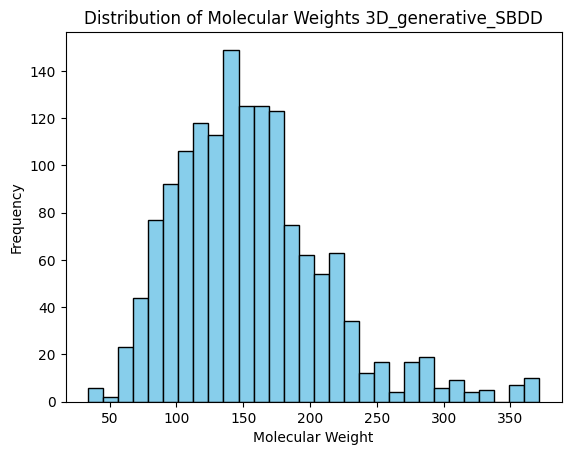

In [28]:
def calculate_molecular_weights(smiles_list):
    """Calculate molecular weights for a list of SMILES strings."""
    molecular_weights = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            mw = Descriptors.MolWt(mol)
            molecular_weights.append(mw)
    return molecular_weights

def plot_molecular_weight_distribution(molecular_weights, bins=30):
    """Plot the distribution of molecular weights as a histogram."""
    plt.hist(molecular_weights, bins=bins, color='skyblue', edgecolor='black')
    plt.title("Distribution of Molecular Weights 3D_generative_SBDD")
    plt.xlabel("Molecular Weight")
    plt.ylabel("Frequency")
    plt.show()
    
molecular_weights = calculate_molecular_weights(df.SMILES.tolist())
plot_molecular_weight_distribution(molecular_weights)


Number of heavy atoms:

### Molecules' performance in ring systems from ZINC22 database druglike molecules

In [29]:
ring_system_lookup_ZINC22 = uru.RingSystemLookup.from_file("/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/ZINC22_rings_system.csv")
res_zinc22 = df.mol.apply(ring_system_lookup_ZINC22.process_mol)
res_zinc22

0                               [(C1CCNC1, 14763048450)]
1                                      [(C1=CCN=C1, 14)]
2                                                     []
3       [(C1CCNC1, 14763048450), (C1CCNC1, 14763048450)]
4                              [(C1=CCCCC1, 1045888108)]
                              ...                       
1496                                                  []
1497                                                  []
1498                                                  []
1499                                   [(C1CN1, 876500)]
1500                                   [(C1=CN=NC1, 84)]
Name: mol, Length: 1501, dtype: object

In [30]:
df[['min_ring','min_freq']] = res_zinc22.apply(uru.get_min_ring_frequency).tolist()
df

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,OC1CCCN1,<rdkit.Chem.rdchem.Mol object at 0x7289d59b3ed0>,[C1CCNC1],C1CCNC1,14763048450,"InChI=1S/C4H9NO/c6-4-2-1-3-5-4/h4-6H,1-3H2",True,True
1,OC1C=CC=N1,<rdkit.Chem.rdchem.Mol object at 0x7289d59b3f40>,[C1=CCN=C1],C1=CCN=C1,14,"InChI=1S/C4H5NO/c6-4-2-1-3-5-4/h1-4,6H",True,True
2,CC(C)CNNCC(C)(N)O,<rdkit.Chem.rdchem.Mol object at 0x7289d59b8040>,[],,-1,"InChI=1S/C7H19N3O/c1-6(2)4-9-10-5-7(3,8)11/h6,...",True,True
3,CC1(O)NCCC1NCC1CCCN1,<rdkit.Chem.rdchem.Mol object at 0x7289d59b80b0>,"[C1CCNC1, C1CCNC1]",C1CCNC1,14763048450,InChI=1S/C10H21N3O/c1-10(14)9(4-6-13-10)12-7-8...,True,True
4,CC(N)(O)C([NH])NCC1CC=CCC1,<rdkit.Chem.rdchem.Mol object at 0x7289d59b8120>,[C1=CCCCC1],C1=CCCCC1,1045888108,"InChI=1S/C10H20N3O/c1-10(12,14)9(11)13-7-8-5-3...",True,True
...,...,...,...,...,...,...,...,...
1496,OC[PH](O)(O)O,<rdkit.Chem.rdchem.Mol object at 0x7289d59e7760>,[],,-1,"InChI=1S/CH7O4P/c2-1-6(3,4)5/h2-6H,1H2",True,True
1497,COP(=O)(O)O,<rdkit.Chem.rdchem.Mol object at 0x7289d59e77d0>,[],,-1,"InChI=1S/CH5O4P/c1-5-6(2,3)4/h1H3,(H2,2,3,4)",True,True
1498,CC(C)OP(=O)(O)O,<rdkit.Chem.rdchem.Mol object at 0x7289d59e7920>,[],,-1,"InChI=1S/C3H9O4P/c1-3(2)7-8(4,5)6/h3H,1-2H3,(H...",True,True
1499,O=P(O)(O)OCCC1CN1,<rdkit.Chem.rdchem.Mol object at 0x7289d59e7a00>,[C1CN1],C1CN1,876500,"InChI=1S/C4H10NO4P/c6-10(7,8)9-2-1-4-3-5-4/h4-...",True,True


In [31]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

Since we already used inchi key to remove redundance, no need to do it again.

In [32]:
filtered_df_ring_freq = df[(df.min_freq > 100) & (df.min_freq != -1)]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,OC1CCCN1,<rdkit.Chem.rdchem.Mol object at 0x7289d59b3ed0>,[C1CCNC1],C1CCNC1,14763048450,"InChI=1S/C4H9NO/c6-4-2-1-3-5-4/h4-6H,1-3H2",True,True
3,CC1(O)NCCC1NCC1CCCN1,<rdkit.Chem.rdchem.Mol object at 0x7289d59b80b0>,"[C1CCNC1, C1CCNC1]",C1CCNC1,14763048450,InChI=1S/C10H21N3O/c1-10(14)9(4-6-13-10)12-7-8...,True,True
4,CC(N)(O)C([NH])NCC1CC=CCC1,<rdkit.Chem.rdchem.Mol object at 0x7289d59b8120>,[C1=CCCCC1],C1=CCCCC1,1045888108,"InChI=1S/C10H20N3O/c1-10(12,14)9(11)13-7-8-5-3...",True,True
5,CC1CC(O)(CN=CC2CCCC2)NO1,<rdkit.Chem.rdchem.Mol object at 0x7289d59b8190>,"[C1CNOC1, C1CCCC1]",C1CNOC1,109818552,"InChI=1S/C11H20N2O2/c1-9-6-11(14,13-15-9)8-12-...",True,True
6,CC1(O)NCCC1NCc1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x7289d59b8200>,"[C1CCNC1, c1ccccc1]",C1CCNC1,14763048450,InChI=1S/C12H18N2O/c1-12(15)11(7-8-14-12)13-9-...,True,True
...,...,...,...,...,...,...,...,...
1489,COc1ccc(CC2C3CCNCC32)cc1,<rdkit.Chem.rdchem.Mol object at 0x7289d59e7370>,"[c1ccccc1, C1CC2CC2CN1]",C1CC2CC2CN1,179514,InChI=1S/C14H19NO/c1-16-11-4-2-10(3-5-11)8-13-...,True,True
1490,C1=CC(Cc2ccc3c(c2)OCO3)CCN1,<rdkit.Chem.rdchem.Mol object at 0x7289d59e73e0>,"[C1=CNCCC1, c1ccc2c(c1)OCO2]",C1=CNCCC1,1969878,InChI=1S/C13H15NO2/c1-2-12-13(16-9-15-12)8-11(...,True,True
1492,c1cc2c(cc1CC1CCNCC1)OCO2,<rdkit.Chem.rdchem.Mol object at 0x7289d59e74c0>,"[c1ccc2c(c1)OCO2, C1CCNCC1]",c1ccc2c(c1)OCO2,108513132,InChI=1S/C13H17NO2/c1-2-12-13(16-9-15-12)8-11(...,True,True
1493,COc1ccc(CCC2CCNCC2)cc1,<rdkit.Chem.rdchem.Mol object at 0x7289d59e7530>,"[c1ccccc1, C1CCNCC1]",C1CCNCC1,12225942610,InChI=1S/C14H21NO/c1-16-14-6-4-12(5-7-14)2-3-1...,True,True


In [33]:
filtered_df_ring_freq = df[(df.min_freq > 0) & (df.min_freq != -1)]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,OC1CCCN1,<rdkit.Chem.rdchem.Mol object at 0x7289d59b3ed0>,[C1CCNC1],C1CCNC1,14763048450,"InChI=1S/C4H9NO/c6-4-2-1-3-5-4/h4-6H,1-3H2",True,True
1,OC1C=CC=N1,<rdkit.Chem.rdchem.Mol object at 0x7289d59b3f40>,[C1=CCN=C1],C1=CCN=C1,14,"InChI=1S/C4H5NO/c6-4-2-1-3-5-4/h1-4,6H",True,True
3,CC1(O)NCCC1NCC1CCCN1,<rdkit.Chem.rdchem.Mol object at 0x7289d59b80b0>,"[C1CCNC1, C1CCNC1]",C1CCNC1,14763048450,InChI=1S/C10H21N3O/c1-10(14)9(4-6-13-10)12-7-8...,True,True
4,CC(N)(O)C([NH])NCC1CC=CCC1,<rdkit.Chem.rdchem.Mol object at 0x7289d59b8120>,[C1=CCCCC1],C1=CCCCC1,1045888108,"InChI=1S/C10H20N3O/c1-10(12,14)9(11)13-7-8-5-3...",True,True
5,CC1CC(O)(CN=CC2CCCC2)NO1,<rdkit.Chem.rdchem.Mol object at 0x7289d59b8190>,"[C1CNOC1, C1CCCC1]",C1CNOC1,109818552,"InChI=1S/C11H20N2O2/c1-9-6-11(14,13-15-9)8-12-...",True,True
...,...,...,...,...,...,...,...,...
1492,c1cc2c(cc1CC1CCNCC1)OCO2,<rdkit.Chem.rdchem.Mol object at 0x7289d59e74c0>,"[c1ccc2c(c1)OCO2, C1CCNCC1]",c1ccc2c(c1)OCO2,108513132,InChI=1S/C13H17NO2/c1-2-12-13(16-9-15-12)8-11(...,True,True
1493,COc1ccc(CCC2CCNCC2)cc1,<rdkit.Chem.rdchem.Mol object at 0x7289d59e7530>,"[c1ccccc1, C1CCNCC1]",C1CCNCC1,12225942610,InChI=1S/C14H21NO/c1-16-14-6-4-12(5-7-14)2-3-1...,True,True
1495,COc1ccc2c(c1)C2CC1=CCNCC1,<rdkit.Chem.rdchem.Mol object at 0x7289d59e7610>,"[c1ccc2c(c1)C2, C1=CCNCC1]",c1ccc2c(c1)C2,2,InChI=1S/C14H17NO/c1-16-11-2-3-12-13(14(12)9-1...,True,True
1499,O=P(O)(O)OCCC1CN1,<rdkit.Chem.rdchem.Mol object at 0x7289d59e7a00>,[C1CN1],C1CN1,876500,"InChI=1S/C4H10NO4P/c6-10(7,8)9-2-1-4-3-5-4/h4-...",True,True


In [34]:
filtered_df_ring_freq = df[(df.min_freq > 10) & (df.min_freq != -1)]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,OC1CCCN1,<rdkit.Chem.rdchem.Mol object at 0x7289d59b3ed0>,[C1CCNC1],C1CCNC1,14763048450,"InChI=1S/C4H9NO/c6-4-2-1-3-5-4/h4-6H,1-3H2",True,True
1,OC1C=CC=N1,<rdkit.Chem.rdchem.Mol object at 0x7289d59b3f40>,[C1=CCN=C1],C1=CCN=C1,14,"InChI=1S/C4H5NO/c6-4-2-1-3-5-4/h1-4,6H",True,True
3,CC1(O)NCCC1NCC1CCCN1,<rdkit.Chem.rdchem.Mol object at 0x7289d59b80b0>,"[C1CCNC1, C1CCNC1]",C1CCNC1,14763048450,InChI=1S/C10H21N3O/c1-10(14)9(4-6-13-10)12-7-8...,True,True
4,CC(N)(O)C([NH])NCC1CC=CCC1,<rdkit.Chem.rdchem.Mol object at 0x7289d59b8120>,[C1=CCCCC1],C1=CCCCC1,1045888108,"InChI=1S/C10H20N3O/c1-10(12,14)9(11)13-7-8-5-3...",True,True
5,CC1CC(O)(CN=CC2CCCC2)NO1,<rdkit.Chem.rdchem.Mol object at 0x7289d59b8190>,"[C1CNOC1, C1CCCC1]",C1CNOC1,109818552,"InChI=1S/C11H20N2O2/c1-9-6-11(14,13-15-9)8-12-...",True,True
...,...,...,...,...,...,...,...,...
1490,C1=CC(Cc2ccc3c(c2)OCO3)CCN1,<rdkit.Chem.rdchem.Mol object at 0x7289d59e73e0>,"[C1=CNCCC1, c1ccc2c(c1)OCO2]",C1=CNCCC1,1969878,InChI=1S/C13H15NO2/c1-2-12-13(16-9-15-12)8-11(...,True,True
1492,c1cc2c(cc1CC1CCNCC1)OCO2,<rdkit.Chem.rdchem.Mol object at 0x7289d59e74c0>,"[c1ccc2c(c1)OCO2, C1CCNCC1]",c1ccc2c(c1)OCO2,108513132,InChI=1S/C13H17NO2/c1-2-12-13(16-9-15-12)8-11(...,True,True
1493,COc1ccc(CCC2CCNCC2)cc1,<rdkit.Chem.rdchem.Mol object at 0x7289d59e7530>,"[c1ccccc1, C1CCNCC1]",C1CCNCC1,12225942610,InChI=1S/C14H21NO/c1-16-14-6-4-12(5-7-14)2-3-1...,True,True
1499,O=P(O)(O)OCCC1CN1,<rdkit.Chem.rdchem.Mol object at 0x7289d59e7a00>,[C1CN1],C1CN1,876500,"InChI=1S/C4H10NO4P/c6-10(7,8)9-2-1-4-3-5-4/h4-...",True,True


### Molecules' performance in ring systems from ZINC20 database druglike molecules

In [33]:
ring_system_lookup_ZINC20 = uru.RingSystemLookup.from_file("/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/ZINC20_rings_ststem.csv")
res_zinc20 = df.mol.apply(ring_system_lookup_ZINC20.process_mol)
res_zinc20

0                             [(C1CCNC1, 136781602)]
1                                  [(C1=CCN=C1, 80)]
2                                                 []
3       [(C1CCNC1, 136781602), (C1CCNC1, 136781602)]
4                             [(C1=CCCCC1, 3763844)]
                            ...                     
1496                                              []
1497                                              []
1498                                              []
1499                                 [(C1CN1, 4401)]
1500                               [(C1=CN=NC1, 30)]
Name: mol, Length: 1501, dtype: object

In [34]:
df[['min_ring','min_freq']] = res_zinc20.apply(uru.get_min_ring_frequency).tolist()
df

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,OC1CCCN1,<rdkit.Chem.rdchem.Mol object at 0x7d59683c3d10>,[C1CCNC1],C1CCNC1,136781602,"InChI=1S/C4H9NO/c6-4-2-1-3-5-4/h4-6H,1-3H2",True,True
1,OC1C=CC=N1,<rdkit.Chem.rdchem.Mol object at 0x7d59683c3ed0>,[C1=CCN=C1],C1=CCN=C1,80,"InChI=1S/C4H5NO/c6-4-2-1-3-5-4/h1-4,6H",True,True
2,CC(C)CNNCC(C)(N)O,<rdkit.Chem.rdchem.Mol object at 0x7d59683c3f40>,[],,-1,"InChI=1S/C7H19N3O/c1-6(2)4-9-10-5-7(3,8)11/h6,...",True,True
3,CC1(O)NCCC1NCC1CCCN1,<rdkit.Chem.rdchem.Mol object at 0x7d59683c4040>,"[C1CCNC1, C1CCNC1]",C1CCNC1,136781602,InChI=1S/C10H21N3O/c1-10(14)9(4-6-13-10)12-7-8...,True,True
4,CC(N)(O)C([NH])NCC1CC=CCC1,<rdkit.Chem.rdchem.Mol object at 0x7d59683c40b0>,[C1=CCCCC1],C1=CCCCC1,3763844,"InChI=1S/C10H20N3O/c1-10(12,14)9(11)13-7-8-5-3...",True,True
...,...,...,...,...,...,...,...,...
1496,OC[PH](O)(O)O,<rdkit.Chem.rdchem.Mol object at 0x7d59683f36f0>,[],,-1,"InChI=1S/CH7O4P/c2-1-6(3,4)5/h2-6H,1H2",True,True
1497,COP(=O)(O)O,<rdkit.Chem.rdchem.Mol object at 0x7d59683f3760>,[],,-1,"InChI=1S/CH5O4P/c1-5-6(2,3)4/h1H3,(H2,2,3,4)",True,True
1498,CC(C)OP(=O)(O)O,<rdkit.Chem.rdchem.Mol object at 0x7d59683f38b0>,[],,-1,"InChI=1S/C3H9O4P/c1-3(2)7-8(4,5)6/h3H,1-2H3,(H...",True,True
1499,O=P(O)(O)OCCC1CN1,<rdkit.Chem.rdchem.Mol object at 0x7d59683f3990>,[C1CN1],C1CN1,4401,"InChI=1S/C4H10NO4P/c6-10(7,8)9-2-1-4-3-5-4/h4-...",True,True


In [35]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

In [36]:
filtered_df_ring_freq = df[(df.min_freq > 100) & (df.min_freq != -1)]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,OC1CCCN1,<rdkit.Chem.rdchem.Mol object at 0x7d59683c3d10>,[C1CCNC1],C1CCNC1,136781602,"InChI=1S/C4H9NO/c6-4-2-1-3-5-4/h4-6H,1-3H2",True,True
3,CC1(O)NCCC1NCC1CCCN1,<rdkit.Chem.rdchem.Mol object at 0x7d59683c4040>,"[C1CCNC1, C1CCNC1]",C1CCNC1,136781602,InChI=1S/C10H21N3O/c1-10(14)9(4-6-13-10)12-7-8...,True,True
4,CC(N)(O)C([NH])NCC1CC=CCC1,<rdkit.Chem.rdchem.Mol object at 0x7d59683c40b0>,[C1=CCCCC1],C1=CCCCC1,3763844,"InChI=1S/C10H20N3O/c1-10(12,14)9(11)13-7-8-5-3...",True,True
5,CC1CC(O)(CN=CC2CCCC2)NO1,<rdkit.Chem.rdchem.Mol object at 0x7d59683c4120>,"[C1CNOC1, C1CCCC1]",C1CNOC1,33816,"InChI=1S/C11H20N2O2/c1-9-6-11(14,13-15-9)8-12-...",True,True
6,CC1(O)NCCC1NCc1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x7d59683c4190>,"[C1CCNC1, c1ccccc1]",C1CCNC1,136781602,InChI=1S/C12H18N2O/c1-12(15)11(7-8-14-12)13-9-...,True,True
...,...,...,...,...,...,...,...,...
1488,COc1ccc(CC2C=CNCC2)cc1,<rdkit.Chem.rdchem.Mol object at 0x7d59683f3290>,"[c1ccccc1, C1=CNCCC1]",C1=CNCCC1,158,InChI=1S/C13H17NO/c1-15-13-4-2-11(3-5-13)10-12...,True,True
1490,C1=CC(Cc2ccc3c(c2)OCO3)CCN1,<rdkit.Chem.rdchem.Mol object at 0x7d59683f3370>,"[C1=CNCCC1, c1ccc2c(c1)OCO2]",C1=CNCCC1,158,InChI=1S/C13H15NO2/c1-2-12-13(16-9-15-12)8-11(...,True,True
1492,c1cc2c(cc1CC1CCNCC1)OCO2,<rdkit.Chem.rdchem.Mol object at 0x7d59683f3450>,"[c1ccc2c(c1)OCO2, C1CCNCC1]",c1ccc2c(c1)OCO2,2983768,InChI=1S/C13H17NO2/c1-2-12-13(16-9-15-12)8-11(...,True,True
1493,COc1ccc(CCC2CCNCC2)cc1,<rdkit.Chem.rdchem.Mol object at 0x7d59683f34c0>,"[c1ccccc1, C1CCNCC1]",C1CCNCC1,150683472,InChI=1S/C14H21NO/c1-16-14-6-4-12(5-7-14)2-3-1...,True,True
